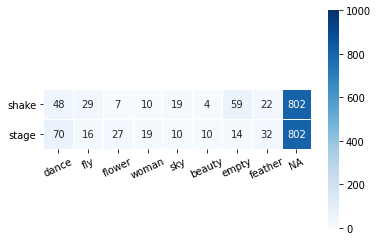

In [2]:
# %load analysis.py
from data_load import *
from common import identity_morphism
from graph_show import *
from my_function import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pyg
import pprint
import math
from scipy.stats import pearsonr,spearmanr

# 連想強度をヒートマップで表示・出力する関数
def adj_matrix(source, target):

    #全てのイメージのデータを取得する
    node_data = get_node_data()  
    
    assoc_net = make_assoc_net(source = "source", target = "target")

    A_node_data = make_node_data(A,node_data)
    B_node_data = make_node_data(B,node_data)

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data:
            if assoc_net.has_edge(B_node,A_node):
                weight = assoc_net[B_node][A_node]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.savefig("./heatmap/nt_weight_"+target+"_"+source+".png",bbox_inches="tight")

    #同一コスライス圏の対象間でのコサイン類似度をヒートマップ出力
def adj_matrix_in_coslice(center):

    #全てのイメージのデータを取得する
    node_data = get_node_data()  
    
    assoc_net = make_assoc_net(source = "source", target = "target")

    center_node_data = make_node_data(center,node_data)

    matrix = list()
    for node1 in center_node_data:
        row = list()
        for node2 in center_node_data:
            if assoc_net.has_edge(node1,node2):
                weight = assoc_net[node1][node2]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=center_node_data,columns=center_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.savefig("./heatmap/nt_weight_in_coslice_"+center+".png",bbox_inches="tight")


# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
def object_TINT_edge_correspondence_heatmap(target, source):
    Corr_DIR = "./object_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    weights = [0.05, 0.275, 0.5, 0.725, 0.95] # 0.05から0.225刻みの線形

    assoc_net = make_assoc_net(source="source",target="target")

    df_edge_corr = pd.read_csv(Corr_DIR+"Date_all_seed_6000_{}_{}_full_anti_1_iter_1000_correspondence.tsv".format(target,source),header=0,encoding="utf-8", sep="\t")
    df_edge_corr = df_edge_corr.fillna("NA")

    A_node_data =list(node_data[node_data[0] == target][1])
    A_node_data.remove(target)
    B_node_data = list(node_data[node_data[0] == source][1])
    B_node_data.remove(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)

    
    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True, fmt="d")
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    # plt.savefig("nt_weight_"+A_name+"_"+B_name+".pdf")
    plt.savefig("./heatmap/object_edge_correspondence_count_"+target+"_"+source+".png")
    # plt.savefig("word2vec_edge_corr_count_"+A_name+"_"+B_name+".png")
     
# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
def tri_TINT_edge_correspondence_heatmap(target, source,tri_dom, tri_cod):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    is_fill_graph = False

    df_edge_corr = pd.read_csv(Corr_DIR+"FOREDGE_Date_all_seed_6000_{}_{}_{}_{}_forced_anti_1_iter_1000_correspondence.tsv".format(target,source,tri_dom,tri_cod),header=0,encoding="utf-8", sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = make_node_data(target, node_data)
    if is_fill_graph:
        B_node_data = make_node_data(source, node_data)
    else:
        B_node_data = [tri_dom,tri_cod] 

    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}
    for B_node in B_node_data:            
        corr_A_nodes = df_edge_corr[(df_edge_corr["B_cod"]==B_node) & (df_edge_corr["B_dom"] == source)]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            if (B_node,A_node) in edge_corr_dict:
                count = edge_corr_dict[(B_node,A_node)]
            else:
                count = 0
            row.append(count)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True,fmt="d",square=True)
    plt.ylim(0,len(B_node_data))
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.savefig("./heatmap/tri_edge_correspondence_count_{}_{}_{}_{}.png".format(target,source,tri_dom,tri_cod),bbox_inches="tight")


    
if __name__ == "__main__":
    # 連想確率、TINTのシミュレーション結果(対象同士、三角構造同士)、人間の比喩解釈データをヒートマップで出力する
    A = "butterfly"
    B = "dancer"
    adj_matrix(A,B)
    object_TINT_edge_correspondence_heatmap(A,B)
    node_data = get_node_data()
    B_node_data = list(node_data[node_data[0] == B][1])
    B_node_data.remove(B)
    for dom, cod in iter.permutations(B_node_data,2):
        tri_TINT_edge_correspondence_heatmap(A,B,dom,cod)